In [ ]:
 !pip install git+https://github.com/vollib/py_vollib
 import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from py_vollib.black_scholes.implied_volatility import implied_volatility
from typing import Union
from scipy import optimize
import cmath
import math
import scipy.integrate as intg
from dataclasses import dataclass
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
implied_volatility_vec = np.vectorize(implied_volatility)
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import RectBivariateSpline


  Cloning https://github.com/vollib/py_vollib to /tmp/pip-req-build-_3mfj9ug
  Running command git clone --filter=blob:none --quiet https://github.com/vollib/py_vollib /tmp/pip-req-build-_3mfj9ug
  Resolved https://github.com/vollib/py_vollib to commit 9fbc623dbc8d7241b935da440a722b49186b9bb1
  Preparing metadata (setup.py) ... done


In [ ]:
def iv_black_scholes(price: Union[float, np.ndarray], S: float,
                     K: Union[float, np.ndarray], t: Union[float, np.ndarray],
                     r: float, is_call: bool):
    """
    Returns implied volatility from given options' prices.
    """
    return implied_volatility_vec(price=price, S=S, K=K, t=t, r=r, flag='c' if is_call else 'p')

def heston_cf(s, v, kappa, theta, sigma, rho, u, t):
    """Characteristic function of the log-price in the Heston model."""
    d = cmath.sqrt((rho * sigma * u * 1j - kappa) ** 2 + sigma ** 2 * (u * 1j + u ** 2))
    g = ((rho * sigma * u * 1j - kappa + d) / (rho * sigma * u * 1j - kappa - d))
    C = (kappa * theta / sigma ** 2 * (
        t * (kappa - rho * sigma * u * 1j - d) -
        2 * cmath.log((1 - g * cmath.exp(-d * t)) / (1 - g))))
    D = ((kappa - rho * sigma * u * 1j - d) / sigma ** 2 *
         ((1 - cmath.exp(-d * t)) / (1 - g * cmath.exp(-d * t))))
    return cmath.exp(C + D * v + u * math.log(s) * 1j)

def heston_cf_copy(s, v, kappa, theta, sigma, rho, u, t):
    """Characteristic function of the log-price in the Heston model."""
    d = cmath.sqrt((rho * sigma * u * 1j - kappa) ** 2 + sigma ** 2 * (u * 1j + u ** 2))
    g = ((rho * sigma * u * 1j - kappa + d) / (rho * sigma * u * 1j - kappa - d))
    C = (kappa * theta / sigma ** 2 * (
        t * (kappa - rho * sigma * u * 1j - d) -
        2 * cmath.log((1 - g * cmath.exp(-d * t)) / (1 - g))))
    D = ((kappa - rho * sigma * u * 1j - d) / sigma ** 2 *
         ((1 - cmath.exp(-d * t)) / (1 - g * cmath.exp(-d * t))))
    return cmath.exp(C + D * v + u * math.log(s) * 1j), d, g, C, D, math.log(s)

def heston_integrand(u, t, k,  s, r, v, kappa, theta, sigma, rho):
    """Integrand in Heston's formula."""
    return (cmath.exp(-1j * u * math.log(k)) / (1j * u) *
            (cmath.exp(r * t) * heston_cf(s, v, kappa, theta, sigma, rho, u - 1j, t) -
             k * heston_cf(s, v, kappa, theta, sigma, rho, u, t))).real

@dataclass
class HestonParams:
    v: float # initial variance V_0
    kappa: float # speed of mean-reversion
    theta: float # long-term mean
    sigma: float # vol of vol
    rho: float # correlation between brownian motions

def heston_scalar(t: float, k: float, s: float, r: float, is_call: bool, heston_params: HestonParams) -> float:
    """Computes the price of a call option by Heston's semi-closed formula.

    This is an auxiliary function which works with scalar expiration time
    and strike. It is called by `call_price`, which allows vectorization.
    """
    call_price = (0.5 * (s - math.exp(- r * t) * k) +
                  1 / math.pi * math.exp(- r * t) *
                  intg.quad(
                    heston_integrand,
                    0, math.inf,
                    args=(t, k, s, r, heston_params.v, heston_params.kappa, heston_params.theta,
                    heston_params.sigma, heston_params.rho))[0])
    if is_call:
        return call_price

    return call_price + k * np.exp(- r * t) - s

def heston(t: Union[float, np.ndarray],
           k: Union[float, np.ndarray],
           s: float, r: float,
           is_call: Union[bool, np.ndarray],
           heston_params: HestonParams) -> Union[float, np.ndarray]:
    """Computes the price of a call option by Heston's semi-closed formula.

        Args:
            t: Expiration time (float or ndarray).
            k: Strike (float or ndarray).
            s: Asset price S_0.
            r: Interest rate r.

        Returns:
            If `t` and `k` are scalars, returns the price of a call option as a
            scalar value. If `t` and/or `k` are arrays, applies NumPy
            broadcasting rules and returns an array of prices.
    """
    b = np.broadcast(t, k)
    if b.nd:  # Vector arguments were supplied
        return np.fromiter(
            (heston_scalar(t_, k_, s, r, is_call, heston_params) for (t_, k_) in b),
            count=b.size, dtype=float).reshape(b.shape)
    else:
        return heston(t, k, s, r, is_call, heston_params)

s = 1
r = 0.02

char, d, g, C, D, log_s = heston_cf_copy(s, 0.1, 2, 0.1, 0.7, -0.2, 1., 1.)
for i in (char, d, g, C, D, log_s):
    print(i)

(0.9484955557135271-0.04443690138875019j)
(2.12866810073951+0.24663309410124215j)
(-0.033291243651302864-0.02270988979353085j)
(-0.029253999627717377-0.026928902174592192j)
(-0.22527922684008506-0.19886744127281547j)
0.0


Расчет цен в модели Хестона (через интегралы)

In [ ]:
def heston(t: Union[float, np.ndarray],
           k: Union[float, np.ndarray],
           s: float, r: float,
           is_call: Union[bool, np.ndarray],
           heston_params: HestonParams) -> Union[float, np.ndarray]:
    """Computes the price of a call option by Heston's semi-closed formula."""
    b = np.broadcast(t, k)
    if b.nd:  # Vector arguments were supplied
        return np.fromiter(
            (heston_scalar(t_, k_, s, r, is_call, heston_params) for (t_, k_) in b),
            count=b.size, dtype=float).reshape(b.shape)
    else:
        # Исправленная строка: вызов scalar-функции вместо рекурсии
        return heston_scalar(t, k, s, r, is_call, heston_params)

params = HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.7, rho=-0.2)
price = heston(t=1.0, k=1.0, s=1.0, r=0.02, is_call=True, heston_params=params)


функции для калибровки

In [ ]:
def objective(p, t, k, s, r, iv):
    prices_heston = np.zeros((t.size, k.size))
    ivs_bs = np.zeros((t.size, k.size))
    for i, strike in enumerate(k):
        is_call = True if strike > s*math.exp(-r*t) else False
        prices_heston[:, i] = heston(t=times, k=strike, s=s, r=r, is_call=is_call, heston_params=HestonParams(*p))
        ivs_bs[:, i] = iv_black_scholes(price=prices_heston[:, i], S=s, K=strike, t=t, r=r, is_call=is_call)

    return np.linalg.norm(ivs_bs - iv)

def calibrate(t: Union[float, np.ndarray], k: np.ndarray,
              iv: np.ndarray, s: float, r: float = 0, min_method: str = "L-BFGS-B"):
        """Calibrates the parameters of the Heston model.

        This function finds the parameters `v`, `kappa`, `sigma`, `theta`,
        `rho` of the model which minimize the sum of squares of the differences
        between market and model implied volatilities. Returns an instance of
        the class with the calibrated parameters.

        Args:
            t : Expiration time (scalar or array).
            k: Array of strikes.
            iv: Array of market implied volatilities.
            s: Initial price.
            r: Interest rate.
            min_method: Minimization method to be used, as accepted by
                `scipy.optimize.minimize`. The method must be able to handle
                bounds.
        """
        v0 = iv[np.abs(k-s).argmin()]**2  # ATM variance
        res = optimize.minimize(
            fun=objective,
            x0=(v0, 1.0, v0, 1.0, -0.5),  # (v, kappa, theta, sigma, rho)
            method=min_method,
            args=(t, k, s, r, iv),
            bounds=[(0, math.inf), (0, math.inf), (0, math.inf), (0, math.inf),
                    (-1, 1)])
        return res

s = 1; r = 0.045; is_call=True
heston_params = HestonParams(v=0.1, kappa=3, theta=0.3, sigma=0.5, rho=-0.2)
strikes = np.linspace(s * 0.65, s * 1.35, 20)
times = np.array([0.5])

prices_heston = np.zeros((times.size, strikes.size))
ivs_bs = np.zeros((times.size, strikes.size))
for i, strike in enumerate(strikes):
    is_call = True if strike > s*math.exp(-r*times) else False
    prices_heston[:, i] = heston(t=times, k=strike, s=s, r=r, is_call=is_call, heston_params=heston_params)
    ivs_bs[:, i] = iv_black_scholes(price=prices_heston[:, i], S=s, K=strike, t=times, r=r, is_call=is_call)

res = calibrate(t=times, k=strikes, iv=ivs_bs.flatten(), s=s, r=r)
res.x

/tmp/ipython-input-30-1631185798.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  is_call = True if strike > s*math.exp(-r*times) else False
/tmp/ipython-input-30-1631185798.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  is_call = True if strike > s*math.exp(-r*t) else False
/tmp/ipython-input-28-1429459242.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  C = (kappa * theta / sigma ** 2 * (
/tmp/ipython-input-28-1429459242.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  C = (kappa * theta / sigma ** 2 * (
/tmp/ipython-input-28-1429459242.py:16: RuntimeWarning: invalid value encountered in

array([ 0.14418519,  1.00468678,  0.38830804,  0.35854545, -0.20361009])

In [ ]:
res

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 7.474763332668413e-05
        x: [ 1.442e-01  1.005e+00  3.883e-01  3.585e-01 -2.036e-01]
      nit: 38
      jac: [ 7.001e-05 -1.163e-04 -3.286e-04 -6.158e-05  1.532e-05]
     nfev: 336
     njev: 56
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

Пробуем реализовать

In [ ]:
heston_params_calibrated = HestonParams(*res.x)

prices_heston_calibrated = np.zeros((times.size, strikes.size))
ivs_bs_calibrated = np.zeros((times.size, strikes.size))
for i, strike in enumerate(strikes):
    is_call = True if strike > s else False
    # Corrected the indexing for times as it's a 1D array of times for each strike
    prices_heston_calibrated[:, i] = heston(t=times, k=strike, s=s, r=r, is_call=is_call, heston_params=heston_params_calibrated)
    ivs_bs_calibrated[:, i] = iv_black_scholes(price=prices_heston_calibrated[:, i], S=s, K=strike, t=times, r=r, is_call=is_call)

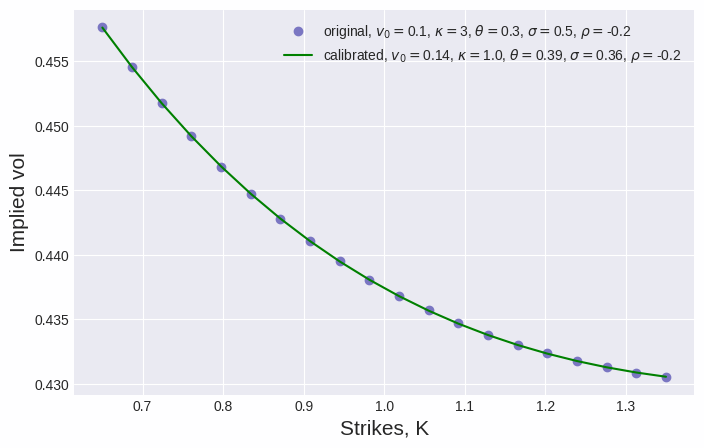

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(strikes, ivs_bs[0], label="original, $v_0=${}, $\kappa=${}, $\\theta=${}, $\sigma=${}, $\\rho=${}".format(heston_params.v, heston_params.kappa,
                                                                                                                      heston_params.theta, heston_params.sigma, heston_params.rho))
plt.plot(strikes, ivs_bs_calibrated[0], color="green", label="calibrated, $v_0=${}, $\kappa=${}, $\\theta=${}, $\sigma=${}, $\\rho=${}".format(round(heston_params_calibrated.v, 2), round(heston_params_calibrated.kappa, 2),
                                                                                                                      round(heston_params_calibrated.theta, 2), round(heston_params_calibrated.sigma, 2), round(heston_params_calibrated.rho, 2)))


plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Strikes, K", fontsize=15)
plt.legend()
plt.show(True)



In [ ]:
print(ivs_bs)
# The ivs_bs array should already be 2D with shape (len(times), len(strikes))
# No need to reshape here if the previous cells are corrected
# ivs_bs_2d = np.array(ivs_bs).reshape(len(times), len(strikes))

[[0.45765138 0.45455805 0.45173775 0.44916867 0.44683139 0.44470844
  0.44278399 0.44104356 0.43947385 0.43806258 0.43679835 0.43567059
  0.43466942 0.43378564 0.43301069 0.43233653 0.43175569 0.43126119
  0.43084652 0.43050561]]


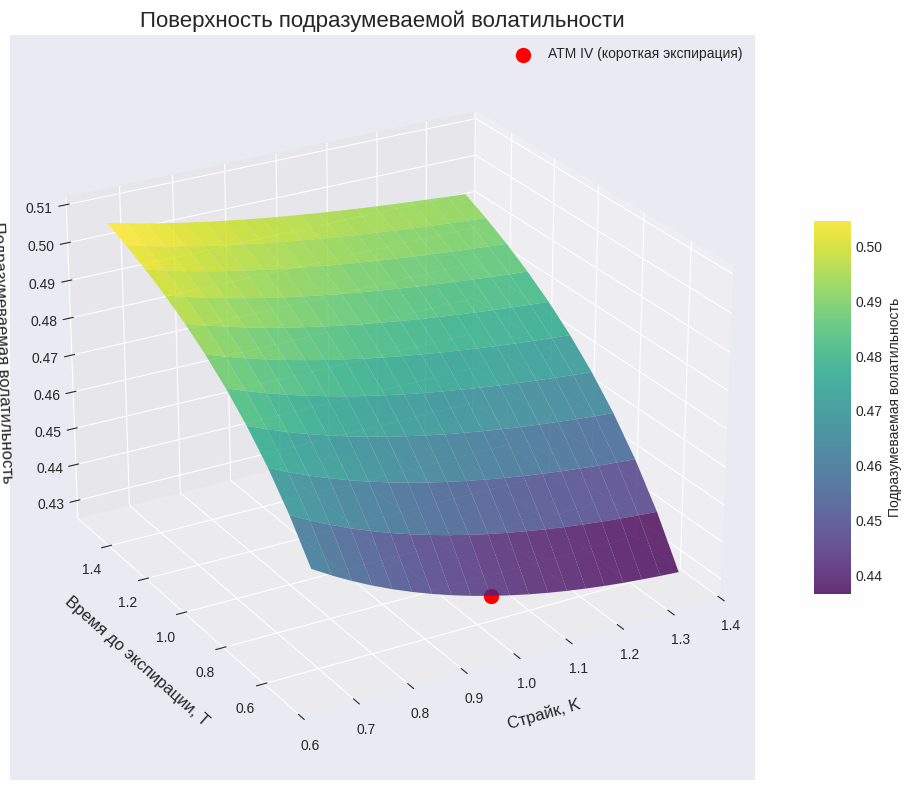

In [ ]:
# Исходные параметры
#s = 1  # Спотовая цена
#r = 0.045  # Безрисковая ставка
#heston_params = HestonParams(v=0.1, kappa=3, theta=0.3, sigma=0.5, rho=-0.2)
strikes_plot = np.linspace(s * 0.65, s * 1.35, 20)  # Массив страйков
times_plot = np.array([ 0.5,0.6,0.7,0.8,0.9, 1.0,1.1,1.2,1.3,1.4,1.5])  # Массив времен до экспирации

# heston_params_calibrated = HestonParams(*res.x)
heston_params_calibrated = heston_params  # Для примера используем исходные параметры

ivs_bs_surface = np.zeros((len(times_plot), len(strikes_plot)))

# Расчет подразумеваемых волатильностей
for i, t in enumerate(times_plot):
    for j, k in enumerate(strikes_plot):
        is_call = True  # Используем call-опционы для консистентности
        price = heston(t=[t], k=k, s=s, r=r, is_call=is_call, heston_params=heston_params_calibrated)[0]
        iv = iv_black_scholes(price=[price], S=s, K=k, t=[t], r=r, is_call=is_call)[0]
        ivs_bs_surface[i, j] = iv

# Проверка на NaN или бесконечные значения
if np.any(np.isnan(ivs_bs_surface)) or np.any(np.isinf(ivs_bs_surface)):
    print("Внимание: ivs_bs_surface содержит NaN или бесконечные значения")
    ivs_bs_surface = np.nan_to_num(ivs_bs_surface, nan=0.0)

# Построение 3D-графика
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Создание сетки для графика
X, Y = np.meshgrid(strikes_plot, times_plot)

# Построение поверхности
surf = ax.plot_surface(X, Y, ivs_bs_surface, cmap='viridis', edgecolor='none', alpha=0.8)

# Подписи осей
ax.set_xlabel('Страйк, K', fontsize=12, labelpad=10)
ax.set_ylabel('Время до экспирации, T', fontsize=12, labelpad=10)
ax.set_zlabel('Подразумеваемая волатильность', fontsize=12, labelpad=10)

# Добавление цветовой шкалы
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Подразумеваемая волатильность')

# Добавление точки ATM для минимального времени
spot_price = s
idx_strike = np.argmin(np.abs(strikes_plot - spot_price))
idx_time = 0
ax.scatter(strikes_plot[idx_strike], times_plot[idx_time], ivs_bs_surface[idx_time, idx_strike],
           color='red', s=100, label='ATM IV (короткая экспирация)')
ax.legend()

# Настройка угла обзора
ax.view_init(elev=25, azim=-120)
plt.title('Поверхность подразумеваемой волатильности', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
strike_list = []
time_list = []
option_type_list = []
iv_list = []

# Расчет для колл и пут опционов
for i, t in enumerate(times_plot):
    for j, k in enumerate(strikes_plot):
        # CALL option
        price_call = heston(t=[t], k=k, s=s, r=r, is_call=True, heston_params=heston_params_calibrated)[0]
        iv_call = iv_black_scholes(price=[price_call], S=s, K=k, t=[t], r=r, is_call=True)[0]

        # PUT option
        price_put = heston(t=[t], k=k, s=s, r=r, is_call=False, heston_params=heston_params_calibrated)[0]
        iv_put = iv_black_scholes(price=[price_put], S=s, K=k, t=[t], r=r, is_call=False)[0]

        # Добавляем данные в списки
        strike_list.extend([k, k])
        time_list.extend([t, t])
        option_type_list.extend(['call', 'put'])
        iv_list.extend([iv_call, iv_put])

# Создаем датафрейм
iv_dataset = pd.DataFrame({
    'strike': strike_list,
    'time_to_expiry': time_list,
    'option_type': option_type_list,
    'implied_volatility': iv_list
})

# Обработка некорректных значений
iv_dataset['implied_volatility'] = iv_dataset['implied_volatility'].replace(
    [np.inf, -np.inf], np.nan
).fillna(0)


# Выводим весь датасет
print("Полный датасет подразумеваемых волатильностей:")
print(iv_dataset)
print(f"\nВсего записей: {len(iv_dataset)}")

Полный датасет подразумеваемых волатильностей:
       strike  time_to_expiry option_type  implied_volatility
0    0.650000             0.5        call            0.457651
1    0.650000             0.5         put            0.457651
2    0.686842             0.5        call            0.454558
3    0.686842             0.5         put            0.454558
4    0.723684             0.5        call            0.451738
..        ...             ...         ...                 ...
435  1.276316             1.5         put            0.494077
436  1.313158             1.5        call            0.493696
437  1.313158             1.5         put            0.493696
438  1.350000             1.5        call            0.493338
439  1.350000             1.5         put            0.493338

[440 rows x 4 columns]

Всего записей: 440


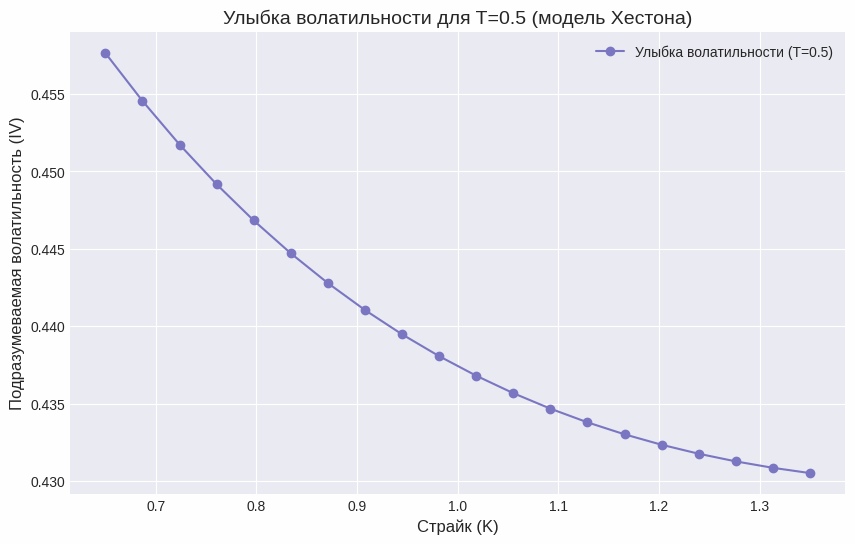

In [ ]:
# Параметры модели
#s = 1   #Спотовая цена
#r =0.045  # Безрисковая ставка
T = 0.5  # Срок до экспирации
heston_params = HestonParams(v=0.1, kappa=3, theta=0.3, sigma=0.5, rho=-0.2)

# Диапазон страйков
strikes = np.linspace(s * 0.65, s * 1.35, 20)

# Массив для хранения подразумеваемой волатильности
ivs = np.zeros_like(strikes)

# Расчет цен опционов и подразумеваемой волатильности
for i, K in enumerate(strikes):
    is_call = True if K > s else False  # Определяем тип опциона
    price = heston(t=[T], k=K, s=s, r=r, is_call=is_call, heston_params=heston_params)[0]
    ivs[i] = iv_black_scholes(price=[price], S=s, K=K, t=[T], r=r, is_call=is_call)[0]

# Проверка на NaN или бесконечные значения
if np.any(np.isnan(ivs)) or np.any(np.isinf(ivs)):
    print("Внимание: ivs содержит NaN или бесконечные значения")
    ivs = np.nan_to_num(ivs, nan=0.0)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(strikes, ivs, marker='o', label='Улыбка волатильности (T=0.5)')
plt.xlabel('Страйк (K)', fontsize=12)
plt.ylabel('Подразумеваемая волатильность (IV)', fontsize=12)
plt.title('Улыбка волатильности для T=0.5 (модель Хестона)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Вывод графиков для сравнения откалиброванной поверхности и исходной

Среднеквадратичная ошибка (MSE): 0.001655


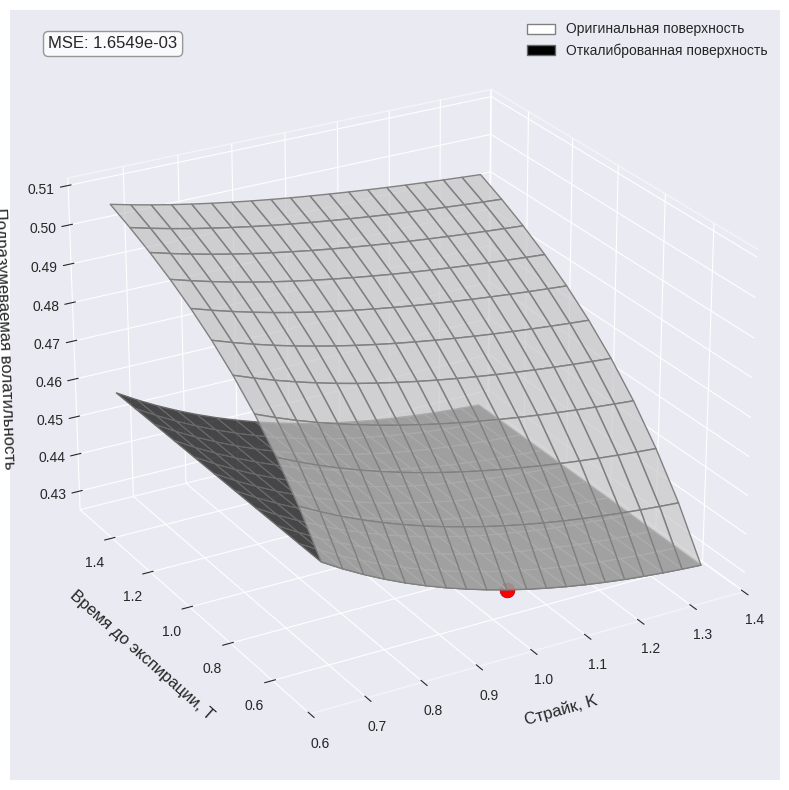

In [ ]:
# Расчет среднеквадратичной ошибки (MSE)
mse = np.mean((ivs_bs_surface - ivs_bs_calibrated) ** 2)
print(f"Среднеквадратичная ошибка (MSE): {mse:.6f}")

# Построение 3D-графика
fig = plt.figure(figsize=(12, 8), facecolor='white')
ax = fig.add_subplot(111, projection='3d')

# Создание сетки для графика
X, Y = np.meshgrid(strikes_plot, times_plot)

# Построение оригинальной поверхности (белый)
surf_original = ax.plot_surface(
    X, Y, ivs_bs_surface,
    color='white',
    edgecolor='gray',
    alpha=0.7,
    shade=True
)

# Построение откалиброванной поверхности (черный)
surf_calibrated = ax.plot_surface(
    X, Y, ivs_bs_calibrated,
    color='black',
    edgecolor='dimgray',
    alpha=0.7,
    shade=True
)

# Подписи осей
ax.set_xlabel('Страйк, K', fontsize=12, labelpad=10)
ax.set_ylabel('Время до экспирации, T', fontsize=12, labelpad=10)
ax.set_zlabel('Подразумеваемая волатильность', fontsize=12, labelpad=10)

# Добавление легенды
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='white', edgecolor='gray', label='Оригинальная поверхность'),
    Patch(facecolor='black', edgecolor='dimgray', label='Откалиброванная поверхность')
]
ax.legend(handles=legend_elements, loc='upper right')

# Добавление точки ATM
spot_price = s
idx_strike = np.argmin(np.abs(strikes_plot - spot_price))
idx_time = 0

ax.scatter(strikes_plot[idx_strike], times_plot[idx_time], ivs_bs_surface[idx_time, idx_strike],
           color='red', s=100, label='ATM Оригинал')
ax.scatter(strikes_plot[idx_strike], times_plot[idx_time], ivs_bs_calibrated[idx_time, idx_strike],
           color='blue', s=100, label='ATM Откалиброванная')

# Добавление текста с MSE
mse_text = f'MSE: {mse:.4e}'
ax.text2D(0.05, 0.95, mse_text, transform=ax.transAxes, fontsize=12,
          bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8, edgecolor='gray'))

# Настройка угла обзора
ax.view_init(elev=25, azim=-120)
plt.title('', fontsize=16)
plt.tight_layout()

# Улучшение видимости
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(True, linestyle='--', alpha=0.3)

plt.show()

Расчет локальной волатильности через формулу Дюпира

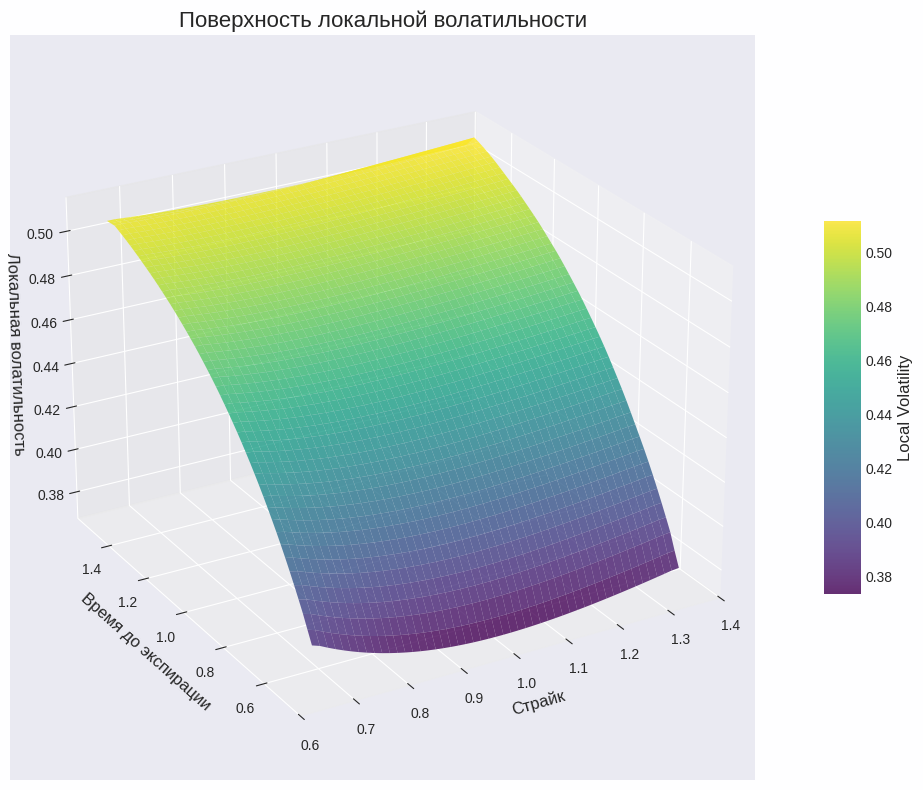

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Создаем более плотную сетку для расчета локальной волатильности
num_strikes = 50
num_expirations = 50

# Определяем диапазоны для новой сетки
init_strikes = strikes_plot
init_expirations = times_plot

# Создаем новую равномерную сетку
strikes = np.linspace(init_strikes.min(), init_strikes.max(), num_strikes)
expirations = np.linspace(init_expirations.min(), init_expirations.max(), num_expirations)

# Создаем интерполятор для подразумеваемой волатильности
spline_iv = RectBivariateSpline(times_plot, strikes_plot, ivs_bs_surface)

# Вычисляем подразумеваемую волатильность на новой сетке
iv = spline_iv(expirations, strikes)

# Создаем сетку для расчетов
strike_grid, expiration_grid = np.meshgrid(strikes, expirations, indexing='ij')
expirations_column = expiration_grid.ravel()
strikes_column = strike_grid.ravel()
ivs_column = iv.T.ravel()  # Транспонируем, чтобы размерности совпали

# Форвардная цена (F_T = S * exp(r*T))
f_t_column = s * np.exp(r * expirations_column)

# Создаем DataFrame для удобства
df = pd.DataFrame({
    'expirations': expirations_column,
    'strikes': strikes_column,
    'ivs': ivs_column,
    'F_T': f_t_column
})

# Преобразуем обратно в сетки
expirations_grid, strikes_grid = np.meshgrid(expirations, strikes, indexing='ij')
iv_surface = df['ivs'].values.reshape(expirations_grid.shape)
F_T_grid = df['F_T'].values.reshape(expirations_grid.shape)

# Вычисляем w (total implied variance) и y (log-moneyness)
w = iv_surface**2 * expirations_grid  # w = sigma^2 * T
y = np.log(strikes_grid / F_T_grid)   # y = ln(K / F_T)

# Рассчитываем производные
dT = np.gradient(expirations_grid, axis=0)
dY = np.gradient(y, axis=1)

# ∂w/∂T
dw_dT = np.gradient(w, axis=0) / dT

# ∂w/∂y
dw_dy = np.gradient(w, axis=1) / dY

# ∂²w/∂y²
d2w_dy2 = np.gradient(dw_dy, axis=1) / dY

# Вычисляем локальную волатильность по формуле Дюпира
numerator = dw_dT
denominator = (
    1
    - (y / w) * dw_dy
    + (1 / 4) * (
        -1 / 4 - 1 / w + (y**2 / w**2)
    ) * (dw_dy**2)
    + (1 / 2) * d2w_dy2
)

# Избегаем деления на ноль и отрицательных значений
denominator = np.where(np.abs(denominator) < 1e-10, np.sign(denominator) * 1e-10, denominator)
local_variance = numerator / denominator
local_variance = np.maximum(local_variance, 0)  # Обеспечиваем неотрицательность
local_volatility = np.sqrt(local_variance)

# Создаем интерполятор для локальной волатильности
spline_loc_vol = RectBivariateSpline(strikes, expirations, local_volatility.T)  # Транспонируем для совместимости

# Визуализация поверхности локальной волатильности
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

# Создаем сетку для построения графика
X, Y = np.meshgrid(strikes, expirations)
Z = spline_loc_vol(strikes, expirations)

# Построение поверхности
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)

# Настройка осей и заголовка
ax.set_xlabel('Страйк', fontsize=12)
ax.set_ylabel('Время до экспирации', fontsize=12)
ax.set_zlabel('Локальная волатильность', fontsize=12)
ax.set_title('Поверхность локальной волатильности', fontsize=16)

# Добавление цветовой шкалы
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Local Volatility', fontsize=12)

# Настройка угла обзора
ax.view_init(elev=25, azim=-120)

plt.tight_layout()
plt.show()

# Дополнительно: 2D срез локальной волатильности для разных экспираций
plt.figure(figsize=(12, 8))

# Выберем несколько временных срезов
selected_expirations = [0.5, 1.0, 1.5]
colors = ['b', 'g', 'r', 'c', 'm']

for i, t in enumerate(selected_expirations):
    # Находим ближайшее доступное время
    idx = np.argmin(np.abs(expirations - t))
    local_vol_slice = local_volatility[:, idx]


